### Imports

In [1]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
import numpy as np
import os

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.math as afwMath


# Firefly client imports
from IPython.display import IFrame

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

This notebook requires the package `obs_lsst`, which is not currently distributed in the LSP. If the following cell raises an exception, see the instructions in `welcome_to_FE55.ipynb`.

In [3]:
import eups
assert eups.getSetupVersion("obs_lsst")

In [6]:
import lsst.eotest.image_utils as imutil

### Set up the config for the ISR task.  This essentially turns off all processing other than overscan and bias correction.

In [4]:
isr_config = IsrTask.ConfigClass()

isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doAddDistortionModel=False
isr_config.doLinearize=False
isr_config.doSaturationInterpolation=False

### Construct the `IsrTask` with the above configuration

In [5]:
isr = IsrTask(config=isr_config)

### Setup firefly to do image visualization

In [ ]:
my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'


ff='{}/firefly/slate.html?__wsch={}'.format(server, my_channel)
IFrame(ff,800,600)

afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, 
                                    name=my_channel)

## Write function to calculate gains given sensor and amplifier number

In [2]:
def calculate_gains(rtm_path, sensor, hduidx):
    
    '''
    rtm_path: str
    
    sensor: 0-8 mapping??
    
    hduidx: range?? mapping??
    '''

    ## Initialize the Butler to point to RTM data
    butler = Butler(rtm_path)

    ## Get individual exposures
    visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FLAT', 'testType': 'FLAT'}) ## what is 'testType' ??
    gain = {}
    exp_time = {}
    
    nn = int(len(visits) / 2)
    
    results = np.empty(nn, dtype=[('visit1', 'int'), ('visit2', 'int'), ('index', 'int'), ('gain', 'f4'), ('exp_time', 'f4')])


    i = 0
    ## Assuming pairs are visits listed one after another
    for visit1, visit2 in zip(visits[:-1:2], visits[1::2]): # loop over pairs of images
        # Get ISR data for first image
        dId = {'visit': visit1, 'detector': sensor}
        raw1 = butler.get('raw', **dId)
        bias1 = butler.get('bias', **dId)
        time1 = raw1.getInfo().getVisitInfo().getExposureTime()

        # Get ISR data for second image
        dId = {'visit': visit2, 'detector': sensor}
        raw2 = butler.get('raw', **dId)
        bias2 = butler.get('bias', **dId)
        time2 = raw2.getInfo().getVisitInfo().getExposureTime()
        if abs(time1 - time2) > 0.01:
            "Mismatched exptimes"
            continue


        # run ISR on both images
        result1 = isr.run(raw1, bias=bias1)
        result2 = isr.run(raw2, bias=bias2)

        detector = result1.exposure.getDetector()
        amp = detector[hduidx]

        sub_im1 = result1.exposure.getMaskedImage()[amp.getBBox()]
        #arr1 = sub_im1.getImage().getArray()
        sub_im2 = result2.exposure.getMaskedImage()[amp.getBBox()]
        #arr2 = sub_im2.getImage().getArray()

        # From RHL, 1/g = <(I1-I2)**2/(I1+I2)>
        diff_im = sub_im1.clone()
        diff_im -= sub_im2

        sum_im = sub_im1.clone()
        sum_im += sub_im2

        diff_im *= diff_im
        diff_im /= sum_im

        stats = afwMath.makeStatistics(diff_im, afwMath.MEDIAN | afwMath.MEAN)
        # Compute gain for this amp.
        gain[visit1] = 1/stats.getValue(afwMath.MEAN)
        exp_time[visit1] = time1
        results[i]['visit1'] = visit1
        results[i]['visit2'] = visit2
        results[i]['index'] = i
        results[i]['gain'] = gain[visit1]
        results[i]['exp_time'] = exp_time[visit1]
        #print("visit %i,%i -- %i of %i -- gain=%f, exposure time(s)=%f"%(visit1, visit2, i, len(visits)/2, gain[visit1], exp_time[visit1], ))
        print(i, visit1, visit2)
        i += 1
    return(results)

In [67]:
sensor2_amp2_gains = calculate_gains( '/project/bootcamp/repo_RTM-007/', 2, 2)

0 258339739 258339769
1 258339807 258339839
2 258339875 258339908
3 258339945 258339976
4 258340014 258340047


In [ ]:
afw_display.mtv(sub_im1) # display an example image

In [ ]:
visit_keys = exp_time.keys()
x = [exp_time[visit] for visit in visit_keys]
y = [gain[visit] for visit in visit_keys]

In [ ]:
plt.scatter(x, y)
plt.ylim(0, 1)

## Test effects of different bias/offset corrections on gain calculations

In [7]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
## butler.getKeys('raw')
## help(butler)
visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FLAT', 'testType': 'FLAT'})

In [8]:
## Define global variables
visit = visits[0]
sensor = 2
amp = 'C11'

In [14]:
## Access images from the butler
dId = {'visit': visit, 'detector': sensor}
raw1 = butler.get('raw', **dId)
bias1 = butler.get('bias', **dId)

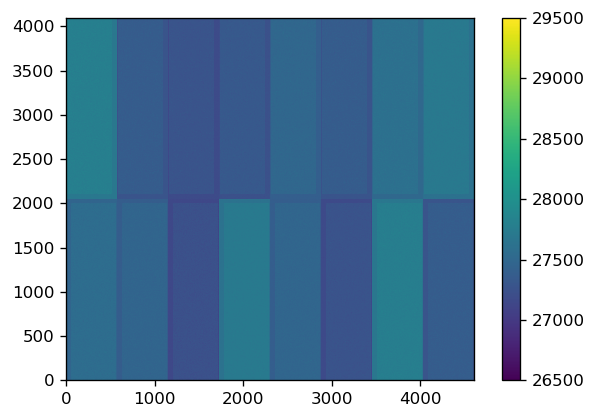

In [10]:
## What do these images look like?
plt.imshow(raw1.getImage().getArray(), origin='lower', vmin=26500, vmax=29500)
plt.colorbar()
plt.show()

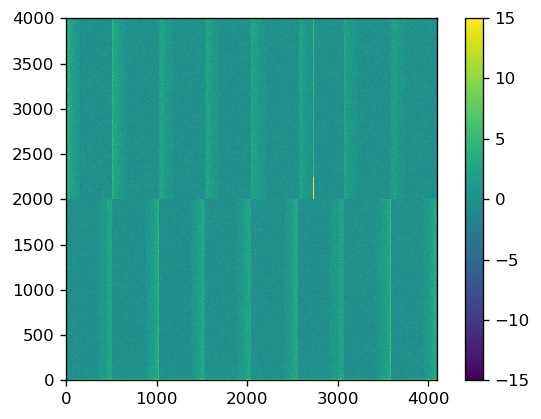

In [11]:
plt.imshow(bias1.getImage().getArray(), origin='lower', vmin=-15, vmax=15)
plt.colorbar()
plt.show()

### eotest bias/offset correction

In [41]:
def eotest_isr(visit, sensor, amp):
    
    dId = {'visit': visit, 'detector' : sensor}
    raw = butler.get('raw', **dId)
    bias = butler.get('bias', **dId)
    
    flipXY = {'C00':(False, True),
              'C01':(False, True),
              'C02':(False, True),
              'C03':(False, True),
              'C04':(False, True),
              'C05':(False, True),
              'C06':(False, True),
              'C07':(False, True),
              'C10':(True, False),
              'C11':(True, False),
              'C12':(True, False),
              'C13':(True, False),
              'C14':(True, False),
              'C15':(True, False),
              'C16':(True, False),
              'C17':(True, False)}
    
    detector = raw.getDetector()
    data_bbox = detector[amp].getRawBBox()
    image_bbox = detector[amp].getRawDataBBox()
    oscan_bbox = detector[amp].getRawHorizontalOverscanBBox()
    
    im = raw[data_bbox].getMaskedImage().getImage().clone()
    bias_frame = bias[data_bbox].getMaskedImage().getImage().clone()
    
    ## Offset-corrected image
    raw_corr = imutil.unbias_and_trim(im=im, overscan=oscan_bbox, bias_frame=bias_frame, imaging=image_bbox)
    #raw_corr = raw_corr[detector[amp].getRawDataBBox()].clone()
    
    return(raw_corr)

In [42]:
corrected_im = eotest_isr(visit = visit, sensor = sensor, amp = amp)

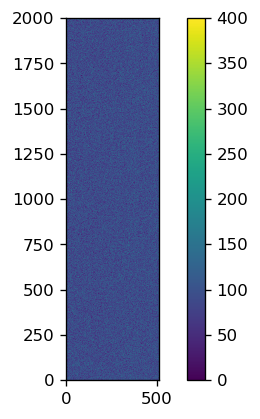

In [43]:
## Note this is only an offset correction! Need to subtract bias image
plt.imshow(corrected_im.getArray(), origin='lower', vmin=0, vmax=400)
plt.colorbar()
plt.show()

### Stack ISR bias/offset correction

In [16]:
## Run ISR bias and offset correction
result1 = isr.run(raw1.clone(), bias=bias1.clone())

In [19]:
## Get subimage for a specific amplifier
detector = result1.exposure.getDetector()
amplifier = detector[amp]

sub_im1 = result1.exposure.getMaskedImage()[amplifier.getBBox()]

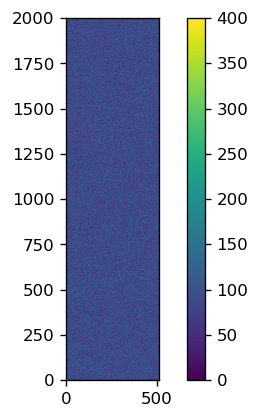

In [37]:
plt.imshow(sub_im1.getImage().clone().getArray(), origin='lower', vmin=0, vmax=400)
plt.colorbar()
plt.show()

### Subtract the two overscan and bias corrected images

In [44]:
diff = corrected_im.getArray() - sub_im1.getImage().clone().getArray()

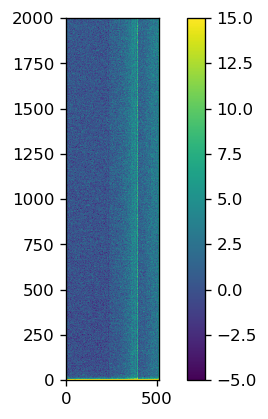

In [47]:
plt.imshow(diff, origin='lower', vmin=-5, vmax=15)
plt.colorbar()
plt.show()

In [ ]:
## make my own super bias
## pattern we see here is not a feature of the electronics of the overscan region - if it were we would see it as a function of row
## could be bias we are using
## compare just the super bias from isr and eotest to see if they are significantly different

In [51]:
#butler.getKeys('raw')
#help(raw1)
#print(raw1.getMetadata())
#help(detector['C00'])

In [ ]:
def get_bboxes(im):
    
    '''
    Parameters
    ----------
    im : raw afw.image.exposure.exposure.ExposureF (although could be other types?)
         usually output from butler.get('raw', **dId)
    
    keyword : region of the full image you want returned (DATASEC, BIASSEC)
    
    '''
    ## Copied from welcome_to_overscans.ipynb
    # for the geometry we've chosen, the y=0 amps are in the top
    # Normally the read corner would tell you this, but there is currently a bug
    
    flipXY = {'C00':(False, True),
              'C01':(False, True),
              'C02':(False, True),
              'C03':(False, True),
              'C04':(False, True),
              'C05':(False, True),
              'C06':(False, True),
              'C07':(False, True),
              'C10':(True, False),
              'C11':(True, False),
              'C12':(True, False),
              'C13':(True, False),
              'C14':(True, False),
              'C15':(True, False),
              'C16':(True, False),
              'C17':(True, False)}
    
    detector = im.getDetector()
    data_bboxes = {}
    oscan_bboxes = {}
    dataregions = {}
    overscans = {}
        
    
    for key, value in flipXY.items():
        data_bboxes[key] = detector[key].getRawBBox()
        oscan_bboxes[key] = detector[key].getRawHorizontalOverscanBBox()
        # since these are views into the pixels, we clone because we want a copy so we don't mess 
        # with the pixels in the original image
        dataregions[key] = im[data_bboxes[key]].getMaskedImage().getImage().clone()
        overscans[key] = im[oscan_bboxes[key]].getMaskedImage().getImage().clone()
    return(data_bboxes, oscan_bboxes, dataregions, overscans)